## [ME459] Programming pratice for Students

## Import ResNet Block

In [1]:
# Original code and checkpoints by Hang Zhang
# https://github.com/zhanghang1989/PyTorch-Encoding

import torchvision.models.resnet

import math
import torch
import os
import sys
import zipfile
import shutil
import torch.utils.model_zoo as model_zoo
import torch.nn as nn
try:
    from urllib import urlretrieve
except ImportError:
    from urllib.request import urlretrieve

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'BasicBlock', 'Bottleneck']

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    """ResNet BasicBlock
    """
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, previous_dilation=1,
                 norm_layer=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=dilation, dilation=dilation, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=previous_dilation, dilation=previous_dilation, bias=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, dilation=1,
                 downsample=None, previous_dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride,
            padding=dilation, dilation=dilation, bias=False)
        self.bn2 = norm_layer(planes)
        self.conv3 = nn.Conv2d(
            planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def _sum_each(self, x, y):
        assert(len(x) == len(y))
        z = []
        for i in range(len(x)):
            z.append(x[i]+y[i])
        return z

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    """Dilated Pre-trained ResNet Model, which preduces the stride of 8 featuremaps at conv5.

    Reference:
        - He, Kaiming, et al. "Deep residual learning for image recognition." CVPR. 2016.
        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, num_classes=1000, dilated=True, multi_grid=False,
                 deep_base=True, norm_layer=nn.BatchNorm2d):
        self.inplanes = 128 if deep_base else 64
        super(ResNet, self).__init__()
        if deep_base:
            self.conv1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
                norm_layer(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                norm_layer(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            )
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer)
            if multi_grid:
                self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                               dilation=4, norm_layer=norm_layer,
                                               multi_grid=True)
            else:
                self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                               dilation=4, norm_layer=norm_layer)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None, multi_grid=False):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion),
            )

        layers = []
        multi_dilations = [4, 8, 16]
        if multi_grid:
            layers.append(block(self.inplanes, planes, stride, dilation=multi_dilations[0],
                                downsample=downsample, previous_dilation=dilation, norm_layer=norm_layer))
        elif dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, dilation=1,
                                downsample=downsample, previous_dilation=dilation, norm_layer=norm_layer))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, dilation=2,
                                downsample=downsample, previous_dilation=dilation, norm_layer=norm_layer))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            if multi_grid:
                layers.append(block(self.inplanes, planes, dilation=multi_dilations[i],
                                    previous_dilation=dilation, norm_layer=norm_layer))
            else:
                layers.append(block(self.inplanes, planes, dilation=dilation, previous_dilation=dilation,
                                    norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



def resnet50(pretrained=False, root='./pretrained', **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

    if pretrained:
        model.load_state_dict(torch.load("./res/resnet50s-a75c83cf.pth"))
        # model.load_state_dict(load_url(model_urls['resnet50'], model_dir=root))
        # model.load_state_dict((torchvision.models.resnet.load_state_dict_from_url(model_urls['resnet50'],progress=True)),strict=False)
    return model



## Design Segmentation Network (PSPNet)

In [2]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models
from itertools import chain

class _PSPModule(nn.Module):
    def __init__(self, in_channels, bin_sizes, norm_layer):
        super(_PSPModule, self).__init__()
        out_channels = in_channels // len(bin_sizes)
        self.stages = nn.ModuleList([self._make_stages(in_channels, out_channels, b_s, norm_layer) 
                                                        for b_s in bin_sizes])
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels+(out_channels * len(bin_sizes)), out_channels, 
                                    kernel_size=3, padding=1, bias=False),
            norm_layer(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )

    def _make_stages(self, in_channels, out_channels, bin_sz, norm_layer):
        prior = nn.AdaptiveAvgPool2d(output_size=bin_sz)
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        bn = norm_layer(out_channels)
        relu = nn.ReLU(inplace=True)
        return nn.Sequential(prior, conv, bn, relu)
    
    def forward(self, features):
        h, w = features.size()[2], features.size()[3]
        pyramids = [features]
        pyramids.extend([F.interpolate(stage(features), size=(h, w), mode='bilinear', 
                                        align_corners=True) for stage in self.stages])
        output = self.bottleneck(torch.cat(pyramids, dim=1))
        return output


class PSPNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, backbone='resnet50'):
        super(PSPNet, self).__init__()
        norm_layer = nn.BatchNorm2d
        model = resnet50(norm_layer=norm_layer)#getattr(resnet, backbone)(pretrained, norm_layer=norm_layer)
        m_out_sz = model.fc.in_features

        self.initial = nn.Sequential(*list(model.children())[:4])
        if in_channels != 3:
            self.initial[0] = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.initial = nn.Sequential(*self.initial)
        
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

        self.master_branch = nn.Sequential(
            _PSPModule(m_out_sz, bin_sizes=[1, 2, 3, 6], norm_layer=norm_layer),
            nn.Conv2d(m_out_sz//4, num_classes, kernel_size=1)
        )

        self.auxiliary_branch = nn.Sequential(
            nn.Conv2d(m_out_sz//2, m_out_sz//4, kernel_size=3, padding=1, bias=False),
            norm_layer(m_out_sz//4),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(m_out_sz//4, num_classes, kernel_size=1)
        )

        # initialize_weights(self.master_branch, self.auxiliary_branch)
        # if freeze_bn: self.freeze_bn()
        # if freeze_backbone: 
            # set_trainable([self.initial, self.layer1, self.layer2, self.layer3, self.layer4], False)

    def forward(self, x):
        input_size = (x.size()[2], x.size()[3])
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_aux = self.layer3(x)
        x = self.layer4(x_aux)

        output = self.master_branch(x)
        output = F.interpolate(output, size=input_size, mode='bilinear')
        output = output[:, :, :input_size[0], :input_size[1]]

        if self.training and self.use_aux:
            aux = self.auxiliary_branch(x_aux)
            aux = F.interpolate(aux, size=input_size, mode='bilinear')
            aux = aux[:, :, :input_size[0], :input_size[1]]
            return output, aux
        return output




## Load Pretrained Model

In [ ]:
net = PSPNet(num_classes=21)

assert torch.cuda.is_available(), 'change your runtime to GPU' 

state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/P_best_0511_76.7.pth")

net.load_state_dict(state_dict)
net.eval()
net.cuda()

## Get prediction from Network

In [15]:
Custom_image= True

In [20]:
from PIL import Image
from torchvision import transforms
import numpy as np
import torch.nn.functional as F




image= np.asarray(Image.open('/content/drive/MyDrive/Colab Notebooks/custom3.jpg'))
MEAN = [0.45734706, 0.43338275, 0.40058118]
STD = [0.23965294, 0.23532275, 0.2398498]

toTensor = transforms.ToTensor()
normTensor = transforms.Normalize(MEAN,STD)
imageT = normTensor(toTensor(image))

if not Custom_image:
  out = net(imageT.unsqueeze(0).cuda())
else:
  img_h, img_w = imageT.size()[1:]
  if img_h>img_w:
    size= (512,384)
  else:
    size= (384,512)
  
  imageT = F.interpolate(imageT.unsqueeze(0), size=size,mode='bilinear',align_corners=True)
  out = net(imageT.cuda())


prob = F.softmax(out,1)
pred = np.argmax(prob[0].detach().cpu().numpy(),axis=0)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


## Visualize the Prediction

In [21]:
def voc_palette(label):
	m = label.astype(np.uint8)
	r,c = m.shape
	cmap = np.zeros((r,c,3), dtype=np.uint8)
	cmap[:,:,0] = (m&1)<<7 | (m&8)<<3
	cmap[:,:,1] = (m&2)<<6 | (m&16)<<2
	cmap[:,:,2] = (m&4)<<5
	cmap[m==255] = [255,255,255]
	return cmap

def denorm(img):
    # ImageNet statistics
    mean_img = [0.485, 0.456, 0.406]
    std_img = [0.229, 0.224, 0.225]

    tf_denorm = transforms.Normalize(mean = [-mean_img[0] / std_img[0], -mean_img[1] / std_img[1], -mean_img[2] / std_img[2]],
                                     std = [1 / std_img[0], 1 / std_img[1], 1 / std_img[2]])

    return tf_denorm(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


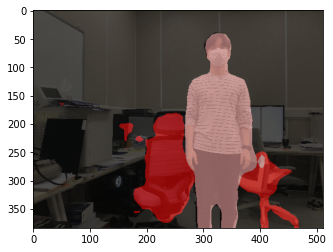

Class Exist::
bg,aeroplane,chair,person,

In [22]:
import matplotlib.pyplot as plt

segmap = voc_palette(pred)
if not Custom_image:
  plt.imshow(image)
else:
  plt.imshow(denorm(imageT)[0].permute(1,2,0))
plt.imshow(segmap,alpha=0.7)
plt.show()

categories = ['bg','aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                  'bus', 'car', 'cat', 'chair', 'cow',
                  'diningtable', 'dog', 'horse', 'motorbike', 'person',
                  'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
class_pred = np.unique(pred)

print("Class Exist::")

for i in range(len(class_pred)):
  print(categories[class_pred[i]]+',',end='')

